### Introduction
In this we will perform Neural Style Transfer using Torch  
Let us describe this method in more detail below

We have a few things here
* Original Image
* Style Image
* Generated Image which is init to Noise
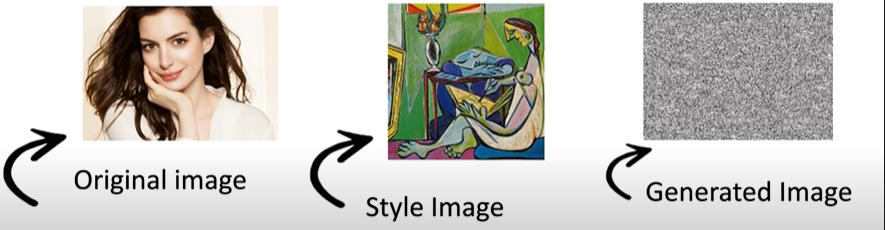

We will take the three images as input and send to VGG19  
This VGG will be modified as, Classifiers will be removed, and the output will be the  
encoding of each of the images

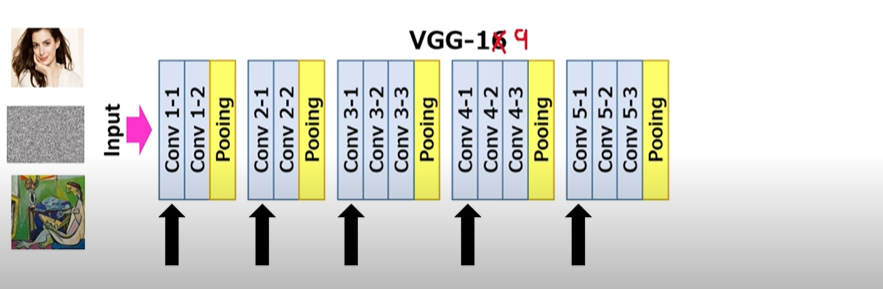

Then we will pass each of them through a **custom** loss function, as below:

$$ 
\mathcal{L}_{Total} (G) = \alpha \mathcal{L}_{content}(C,G) + \beta \mathcal{L}_{style} (S,G)
$$

* G is for Generated Image
* C is Content Image
* S is Style Image

Let us see each of the above losses in detail  

#### Loss Functions

##### Content Loss
It compares the content with the generated image.
It does so by taking the norm across all layers
The content loss is given by the expression  
$$
\mathcal{L}_{content} (C,G) = \frac{1}{2} \lVert a^{[l](C)} - a^{[l](G)} \rVert ^{2}
$$

$a^{[l](G)}$ refers to the activation of layer l of the VGG for Generated Image  
$a^{[l](C)}$ refers to the activation of layer l of the VGG for Content Image

##### Style Loss
Here, style of the generated is compared with the style of the style image  
This is a bit tricky, so, lets look at the formula first.  
  
$$
G_{ij}^{l} = \sum_{k} g_{ik}^{l} \cdot  g_{jk}^{l} \\
S_{ij}^{l} = \sum_{k} s_{ik}^{l} \cdot  s_{jk}^{l}
$$ 
  
The notation is a bit complex, 
We form **Gram Matrix** of Generated and Style Image    
In a Gram Matrix, we multiply the output of a conv layer with its transpose
$G_{ij}^{l}$ and $S_{ij}^{l}$ are the Gram Matrices for layer l of the   
Generated (G) and Style (S) images  

After this is done, we will calculate the style loss as:  
  
$$
\mathcal{L}_{style}(G,S) = \sum_{i,j} (G_{ij}^{l} - S_{ij}^{l})^{2}
$$

### Code

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
vggmodel = models.vgg19(pretrained=True)
model = vggmodel.features
#.features gives us the convlayers

Below we see the architecture of VGG model.  
We know that the resolution of the i/0 changes everytime there is  
a maxpooling layer. It gets reduced by half.  
1,1 -> 2,1 -> 3,1 ... 5,1  
We will take each layer after maxpooling layer
![image](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [4]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        ## chosen features are ones who have different channels
        self.chosen_features = ['0','5', '10', '19', '28']
        self.model = models.vgg19(pretrained=True).features[:29]
    
    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            
            # Here the x is passed through each of the layers, upto 29 as we need
            # 28 only, and then, if we have chosen the features, ones with the 
            # different channels, they are appended to features.
            # those features are returned
            
            if str(layer_num) in self.chosen_features:
                features.append(x)
            
        return features

In [6]:
#hyperparams
image_size = 480
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.08

In [7]:
# This resizes the images and converts to tensor
loader = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
])

orig_loader = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

def load_image(image_name,im_type='original'):
    image = Image.open(image_name)
    if im_type == 'original':
        image = orig_loader(image).unsqueeze(0)
    else:
        image = loader(image).unsqueeze(0)
    # unsqueeze is used to add a separate dimension, for batch index
    return image.to(device)

In [ ]:
import os
os.listdir("NST/in/")

In [9]:
original_img = load_image("NST/in/Like Lover.jpg",'not original')
style_img = load_image("NST/in/styleLover.jpg",'not original')

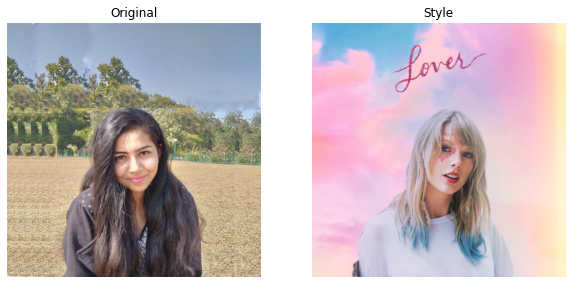

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (10,5))
for i,image in enumerate((original_img,style_img)):    
    plt.subplot(1,2,i+1)
    plt.axis('off')
    plt.title('Original' if i==0 else 'Style')
    x = image.to(device=torch.device('cpu')).squeeze(0).permute(1,2,0)
    plt.imshow(x)

Now, the generated image can be initialized in two ways:
1. As discussed before, it may be Gaussian Noise.
   This may be achieved by
    >```python
    torch.randn(original_img.shape,device,requires_grad = True)
    ```
      
        
2. What gives better results is that if the Generated image  
   is initialized to a copy of the original image
   >```python
    generated = original_img.clone().requires_grad_(True)
    ```

**P.S.** *requires_grad_* is necessary because we will freeze the network, with all the weights and all so that the loss function optimizes only the Generated image.

In [11]:
#generated = torch.randn(original_img.shape, device=device,requires_grad = True)
generated = original_img.clone().requires_grad_(True)

In [12]:
model = VGG().to(device).eval() #freeze weights
optimizer = optim.Adam([generated], lr = learning_rate)

In [13]:
%%time
#generation loop
for step in range(total_steps):
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)
    
    style_loss = original_loss = 0
    
    #now iterating throguh all features
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features):
        
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature)**2)
        
        #gram matrix
        G = gen_feature.view(channel, height*width).mm(
            gen_feature.view(channel, height*width).t()
        )
        
        S = style_feature.view(channel, height*width).mm(
            style_feature.view(channel, height*width).t()
        )
        
        style_loss += torch.mean((G - S)**2)
        
    total_loss = alpha*original_loss + beta*style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step%200 == 0:
        print(f"Step: {step} Loss: {total_loss.item()}")
        save_image(generated, "NST/out/generated {}.png".format(str(step/200)))        
    
    

Step: 0 Loss: 7937239.5
Step: 200 Loss: 455636.25
Step: 400 Loss: 283642.4375
Step: 600 Loss: 226736.296875
Step: 800 Loss: 191651.5625
Step: 1000 Loss: 164424.359375
Step: 1200 Loss: 141625.78125
Step: 1400 Loss: 122482.796875
Step: 1600 Loss: 106210.6875
Step: 1800 Loss: 92064.78125
Step: 2000 Loss: 79519.484375
Step: 2200 Loss: 67777.3984375
Step: 2400 Loss: 56175.74609375
Step: 2600 Loss: 45273.05078125
Step: 2800 Loss: 35976.13671875
Step: 3000 Loss: 28924.865234375
Step: 3200 Loss: 23944.01171875
Step: 3400 Loss: 20468.078125
Step: 3600 Loss: 17968.779296875
Step: 3800 Loss: 16060.953125
Step: 4000 Loss: 14515.2744140625
Step: 4200 Loss: 13199.06640625
Step: 4400 Loss: 12054.5400390625
Step: 4600 Loss: 11049.2890625
Step: 4800 Loss: 10151.642578125
Step: 5000 Loss: 9355.4443359375
Step: 5200 Loss: 8644.12890625
Step: 5400 Loss: 8018.2275390625
Step: 5600 Loss: 7444.56689453125
Step: 5800 Loss: 6945.33544921875
Wall time: 29min 19s


### Output

#### GIF from Images

In [24]:
import imageio
images = []
filenames = os.listdir("NST/out/")
for filename in filenames:
    images.append(imageio.imread("NST/out/"+filename))
imageio.mimsave('NST/out/1NST.gif', images,duration = 0.5)

#### Generated Image at Last Step

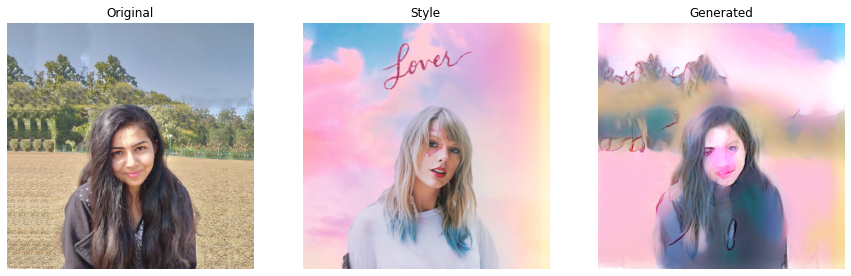

In [28]:
plt.figure(figsize = (15,5))
titles = ['Original','Style','Generated']
for i,image in enumerate((original_img,style_img,load_image("NST/out/5800.png", "not o"))):    
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.title(titles[i])
    x = image.to(device=torch.device('cpu')).squeeze(0).permute(1,2,0)
    plt.imshow(x)